# Pythonのエンジニアリングへの応用例: 実データから近似計算式のパラメーターを求める
組み込み機器などで、温度などの測定をしたい時、実際に欲しい位置で計測できず、何とか計算して近似しなければならないケースが時々あります。
そのとき、

- うまく近似の計算式を作れるか
- 計算式のパラメーターをどうやって決めるのか

ということが問題になります。

この記事では、後者のパラメーターの決め方について、Pythonで`scipy`を使うと簡単に求まる例を紹介します。

　※ 最終的に貧弱な整数演算しか出来ない組み込み機器への応用を想定しています。

## データの読み込み
下記のデータがCSVファイルで準備できているものとして、このデータを読み込むことから始めます。

- t 時刻
- x 実際に得られるセンサーなどの測定値
- y 実際に得たい値、この値をxから近似したい

「yは実際の運用では測定できないので、xの値から近似する」という問題設定です。(開発現場では特殊な方法でyを測定できるものの、運用する段階ではxしか得られない、ということがよく発生します。)

機械学習の教師データy、入力データxに相当します。

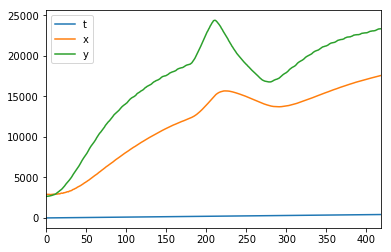

,t,x,y
100,100,8090,14130
101,101,8152,14200
102,102,8220,14310
103,103,8292,14440
104,104,8369,14560


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
from scipy import optimize
import numpy as np

# csv読み込み
datafile = 'xy_data.csv' # データファイル名
df = pandas.read_csv(datafile)
# 可視化してみましょう
df.plot()
plt.show()
# データの数値も表示してみます (100から5個)
df[100:105]

## モデル1 - 1次式で近似
yはxの1.?倍に見えなくもありません。`f(x) = a*x + b`で近似する例で、パラメーターの求め方を見ていきます。

In [6]:
# 近似式を定義する
def f1(x, a, b): # 一つの入力につづけて、必要なパラメーターを列挙
    return a*x + b

# 近似計算を関数にまとめる
def param_solver(f, x, y, debug_print=True):
    '''関数f(x)に対して入力xをyに合うよう初期値guessで調整したパラメーターを計算'''
    params, params_covariance = optimize.curve_fit(f, x, y) # <---------- ここで最適化計算
    if debug_print:
        print('params =', params) # 得られたパラメーター
        print('params_covariance =', params_covariance) # このパラメーターでの共分散
        print('standad deviation errors = ', np.sqrt(np.diag(params_covariance))) # 標準偏差
    return params

# データを一旦numpyデータに変換
x = np.array(df['x'].tolist())
y = np.array(df['y'].tolist())
t = np.array(df['t'].tolist())

# パラメーターを計算
params = param_solver(f=f1, x=x, y=y) 

params = [  1.24075239e+00   2.31148413e+03]
params_covariance = [[  3.47128802e-04  -4.06799576e+00]
 [ -4.06799576e+00   5.46259540e+04]]
standad deviation errors =  [  1.86313929e-02   2.33721959e+02]


### 見つかったパラメーターで近似式を可視化
`(scipy)optimize.curve_fit`で簡単に近似パラメーターが見つかりました。どれだけ近い値が得られるのでしょうか。

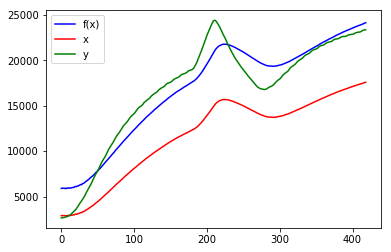

In [7]:
# 可視化を関数にまとめる
def plot_all(f, x, y, params):
    fig, ax = plt.subplots()
    ax.plot(t, f(x, *params), 'b-', label="f(x)")
    ax.plot(t, x if len(np.array(x).shape) == 1 else x[0], 'r-', label="x")
    ax.plot(t, y, 'g-', label="y")
    ax.legend()
    plt.show()

plot_all(f1, x, y, params)

y(緑)に対して、x(赤)を定数倍しただけなので、やはり無理がありました…。モデルを変えてみましょう。

## モデル2 - 2次式を導入
`f(x) = a*x^2 + b*x + c`で近似します。

params = [ -5.82931117e-05   2.42030720e+00  -2.33839533e+03]
params_covariance = [[  1.78832431e-11  -3.61865487e-07   1.42649657e-03]
 [ -3.61865487e-07   7.56116875e-03  -3.16641976e+01]
 [  1.42649657e-03  -3.16641976e+01   1.51375869e+05]]
standad deviation errors =  [  4.22885837e-06   8.69549812e-02   3.89070519e+02]


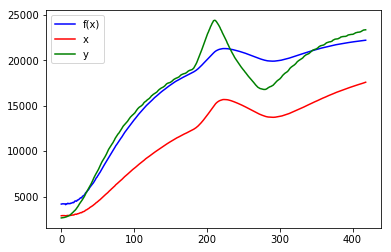

In [8]:
# 近似式を定義する
def f2(x, a, b, c):
    return a*x**2 + b*x + c

# パラメーターを計算
params2 = param_solver(f=f2, x=x, y=y) # guessを3要素にする

# 可視化する
plot_all(f2, x, y, params2)

だいぶ似ましたが、ピークが全く近似できていません。よく見るとxとyではカーブのポイントが時間的にズレているようです。時間要素も考慮しましょう。

## モデル3 - 微分を導入

`f(x) = a*x^2 + b*x + c*dx/dt + d` で微分項 `dx/dt`を使って近似します。

params = [ -3.54499345e-05   2.03961022e+00   3.95514919e+00  -2.84616185e+03]
params_covariance = [[  2.27985415e-12  -4.55332708e-08   2.90736635e-08   1.64730881e-04]
 [ -4.55332708e-08   9.39580914e-04  -4.84532248e-04  -3.67720697e+00]
 [  2.90736635e-08  -4.84532248e-04   5.03391759e-03  -6.46259873e-01]
 [  1.64730881e-04  -3.67720697e+00  -6.46259873e-01   1.79598365e+04]]
standad deviation errors =  [  1.50991859e-06   3.06525841e-02   7.09501063e-02   1.34014314e+02]


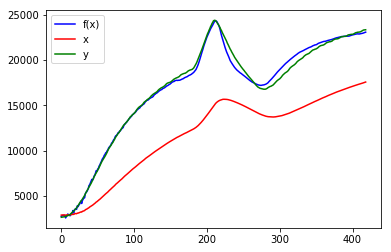

In [9]:
def f3(xs, a, b, c, d):
    x, xdelayed = xs
    dx = x - xdelayed # 微分を遅れ成分との差分で表現
    return a*x**2 + b*x + c*dx + d;

def make_delayed(d, delay_step):
    '''先頭delay_step個をd[0]にして、後端delay_step個を切り捨てたdを作成'''
    d = list(d)
    n = len(d)
    result = np.array([d[0] for i in range(delay_step)] + list(d[:-delay_step]))
    return result

# 10時刻遅れのデータを作る
x10 = make_delayed(x, delay_step=10)

# パラメーターを計算、可視化
params3 = param_solver(f=f3, x=(x, x10), y=y) # xに二つの入力を与えている
plot_all(f3, (x, x10), y, params3)

かなり似ました! しかし、y(緑)と近似したf(x)は後半が少しずれています。
ここでは微分のとり方として単純な`x(t) - x(t-10)`としましたが、この10時刻遅れでよかったのでしょうか。

この遅れ成分(以下td)もパラメーターとして探索してみます。

## 微分近似の最適値を探す

In [10]:
# 時間遅れtdに対して、良さを定量化する評価関数を、目標とf(x)の差分の絶対値(L1距離)の総和として定義する
def cost(td, *args):
    _f, _x, _y = args
    # 遅れデータを作り
    xdelay = make_delayed(d=_x, delay_step=td)
    # 最適化を計算し
    _params = param_solver(f=_f, x=(_x, xdelay), y=_y, debug_print=False)
    # 距離の総和を計算
    return np.sum(np.abs(_y - _f((_x, xdelay), *_params)))

print('cost(td=5) = ', cost(5, f3, x, y))
print('cost(td=10) = ', cost(10, f3, x, y))

cost(td=5) =  178246.4667
cost(td=10) =  149393.276741


まず簡単に評価関数を決めて、試しにtd=5, 10で値を取った所、5よりは10の方が優れていることが定量的に確認出来ました。

ここでもscipyで最適化します。

final optimum td =  23 for cost =  123800.706755


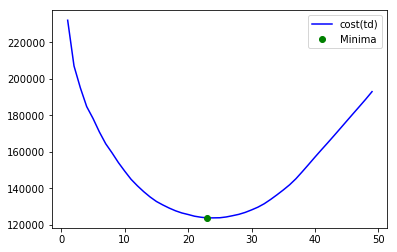

In [11]:
def cost_for_brute(td, *args):
    '''bruteの挙動(最後にtdがリストで与えられる)に合わせたラッパー、常に一つの整数値をcostに与える'''
    try:
        td = int(td[0])
    except:
        pass
    return cost(td, *args)

# 探索実施
result = optimize.brute(cost_for_brute, [slice(1, 50, 1)], args=(f3, x, y), full_output=True)
final_td, final_cost, tds, costs = result # 最適td, 最適cost, 探索範囲のtd, それぞれのcost
final_td = int(final_td[0]) # [23.]のように実数のリストで返っているため、整数へ変換
print('final optimum td = ', final_td, 'for cost = ', final_cost)

# 可視化
fig, ax = plt.subplots()
ax.plot(tds, costs, 'b-', label="cost(td)")
ax.plot(final_td, final_cost, 'go', label="Minima")
ax.legend()
plt.show()

きれいに凸型になり、評価関数の値が一番小さくなる最適解が1つしかないことが分かります。それでは、このパラメーター`td`で近似の様子を可視化します。

params = [ -3.56938479e-05   2.02134829e+00   1.78433928e+00  -2.62914982e+03]
params_covariance = [[  1.41335136e-12  -2.83473596e-08   7.69752574e-09   1.03708164e-04]
 [ -2.83473596e-08   5.86738635e-04  -1.35889230e-04  -2.30772756e+00]
 [  7.69752574e-09  -1.35889230e-04   6.07763010e-04  -9.90337036e-02]
 [  1.03708164e-04  -2.30772756e+00  -9.90337036e-02   1.11544635e+04]]
standad deviation errors =  [  1.18884455e-06   2.42226884e-02   2.46528499e-02   1.05614693e+02]


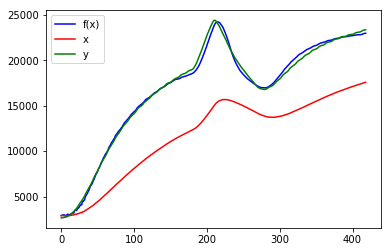

In [12]:
def solve_and_plot_by_td(td, f, x, y):
    # 遅れデータを作り
    xdelay = make_delayed(d=x, delay_step=td)
    # 最適化を計算し
    _params = param_solver(f=f, x=(x, xdelay), y=y)
    plot_all(f, (x, xdelay), y, _params)

solve_and_plot_by_td(final_td, f3, x, y)

かなり似ました。目標のyに対して、f(x)はほとんど重なっています。目標をこれで達成したとして、近似式f3()は果たして最適だったのでしょうか。

例えば、２次項`a*x**2`は必要だったのでしょうか。また、微分はありますが積分項は必要ないのでしょうか。

## モデル4 - ２次項を省く

`f(x) = b*x + c*dx/dt + d` として、 `x^2` を省いて近似します。

final optimum td =  32 for cost =  251326.900162


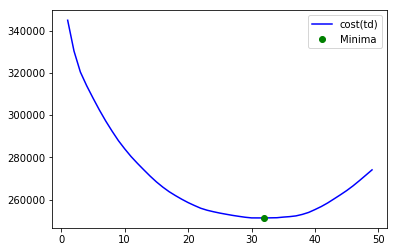

In [13]:
def f4(xs, b, c, d):
    x, xdelayed = xs
    dx = x - xdelayed # 微分を遅れ成分との差分で表現
    return b*x + c*dx + d;

# 探索実施
result = optimize.brute(cost_for_brute, [slice(1, 50, 1)], args=(f4, x, y), full_output=True)
final_td, final_cost, tds, costs = result # 最適td, 最適cost, 探索範囲のtd, それぞれのcost
final_td = int(final_td[0]) # [23.]のように実数のリストで返っているため、整数へ変換
print('final optimum td = ', final_td, 'for cost = ', final_cost)

# 可視化
fig, ax = plt.subplots()
ax.plot(tds, costs, 'b-', label="cost(td)")
ax.plot(final_td, final_cost, 'go', label="Minima")
ax.legend()
plt.show()

コストが悪いことはわかりました。念のため近似の様子も可視化してみましょう。

params = [   1.28868602    1.44297502  176.91492786]
params_covariance = [[  6.30546320e-05   3.59497597e-05  -7.78121379e-01]
 [  3.59497597e-05   1.08222102e-03  -1.60091104e+00]
 [ -7.78121379e-01  -1.60091104e+00   1.21028825e+04]]
standad deviation errors =  [  7.94069468e-03   3.28971279e-02   1.10013101e+02]


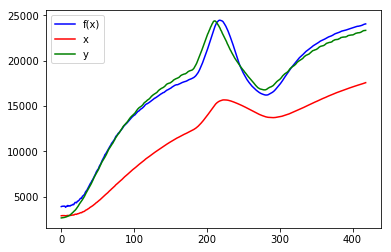

In [21]:
solve_and_plot_by_td(final_td, f4, x, y)

以上のように、２次項が必要だったことは良くわかりました。

次に、積分項を導入してみましょう。

## モデル5 - 積分項を導入

`f(x) = a*x^2 + b*x + c*dx/dt + d*sum(x) + e` で積分項 `sum(x)` を使って近似します。

In [22]:
# 移動区間で積分値を得る。桁あふれを防ぐため、足し合わせるデータ個数で割った値とする => ∴移動平均…
def integral(d, span):
    d = list(d)
    n = len(d)
    dspan = [d[0] for i in range(span - 1)] + d # 先頭にspan-1個追加した配列を準備
    return np.array([sum(dspan[i:i+span])/span for i in range(n)])# 移動しながらspan個足し合わせたデータを作成

# 近似式を定義
def f5(xs, a, b, c, d, e):
    x, xdelay, xsum = xs
    dx = x - xdelay
    return a*x**2 + b*x + c*dx + d*xsum + e

In [16]:
# 積分時間tiに対して、良さを定量化する評価関数を、目標とf(x)の差分の絶対値(L1距離)の総和として定義する
def cost5(ti, *args):
    f, x, xdelay, y = args
    # 積分データを作り
    xsum = integral(x, ti)
    # 最適化を計算し
    params = param_solver(f=f, x=(x, xdelay, xsum), y=y, debug_print=False)
    # 距離の総和を計算
    return np.sum(np.abs(y - f((x, xdelay, xsum), *params)))

# 遅れデータを作り(※最適値は前回求めたものを利用する)
xdelay = make_delayed(d=x, delay_step=final_td)
# 試しにti=10のときのコストを算出
print(cost5(5, f5, x, xdelay, y))
print(cost5(10, f5, x, xdelay, y))

105806.884719
105436.131801


final optimum ti =  47 for cost =  89564.819536


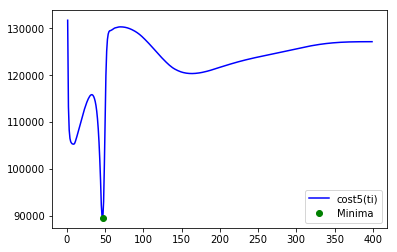

In [17]:
def cost5_for_brute(td, *args):
    '''bruteの挙動(最後にtdがリストで与えられる)に合わせたラッパー、常に一つの整数値をcostに与える'''
    try:
        td = int(td[0])
    except:
        pass
    return cost5(td, *args)

# 探索実施
result = optimize.brute(cost5_for_brute, [slice(1, 400, 1)], args=(f5, x, xdelay, y), full_output=True)
final_ti, final_cost, tis, costs = result # 最適ti, 最適cost, 探索範囲のti, それぞれのcost
final_ti = int(final_ti[0]) # [23.]のように実数のリストで返っているため、整数へ変換
print('final optimum ti = ', final_ti, 'for cost = ', final_cost)

# 可視化
fig, ax = plt.subplots()
ax.plot(tis, costs, 'b-', label="cost5(ti)")
ax.plot(final_ti, final_cost, 'go', label="Minima")
ax.legend()
plt.show()

今度の評価関数は、[1,100)の範囲で3つの局所解を持っていることがわかります。その中で最適な解 47 だということが示されました。

params = [ -3.03782209e-05   9.91815249e+00  -4.26387796e+00  -7.99927214e+00
  -2.47884462e+03]
params_covariance = [[  6.63718559e-13   3.34745759e-08  -2.98614480e-08  -4.66996212e-08
    4.64742006e-05]
 [  3.34745759e-08   7.18603686e-02  -5.03435446e-02  -7.23475214e-02
   -1.40511200e+00]
 [ -2.98614480e-08  -5.03435446e-02   3.54804571e-02   5.08234965e-02
    2.46752985e-01]
 [ -4.66996212e-08  -7.23475214e-02   5.08234965e-02   7.31066200e-02
    3.71334580e-01]
 [  4.64742006e-05  -1.40511200e+00   2.46752985e-01   3.71334580e-01
    4.98091129e+03]]
standad deviation errors =  [  8.14689241e-07   2.68067843e-01   1.88362568e-01   2.70382359e-01
   7.05755715e+01]


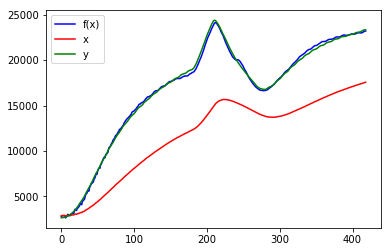

In [18]:
def solve_and_plot_by_ti(ti, f, x, xdelay, y):
    # 積分データを作り
    xsum = integral(x, ti)
    # 最適化を計算し
    _params = param_solver(f=f, x=(x, xdelay, xsum), y=y)
    plot_all(f, (x, xdelay, xsum), y, _params)

solve_and_plot_by_ti(final_ti, f5, x, xdelay, y)

依然評価関数が返すL1距離は90,000と大きいように思えますが、グラフはほぼ近似式が目標に一致しているところまで到達しました。

ここまで最適な近似式
```python
def f5(xs, a, b, c, d, e):
    x, xdelay, xsum = xs
    dx = x - xdelay
    return a*x**2 + b*x + c*dx + d*xsum + e
```
に対して、パラメーターがそれぞれ下記の値を使えばいいということが得られました。
```python
params = [ -3.03782209e-05   9.91815249e+00  -4.26387796e+00  -7.99927214e+00 -2.47884462e+03]
```

最後に、更に二つ検討してみます。

- 本当にx^2の項は必要だったのか??
- 組み込み機器などに応用するとき、50個の移動平均バッファを持てないケースが有る。この場合どうするのか?

## モデル6 - ２次項の必要性を再確認

パラメーター a = params[0] の値を見てみると、`-3.03782209e-05` となっています。

つまり、***２次項はほとんど結果に寄与しておらず不要では??*** とも考えられます。実際に式を変えて確認してみます。

final optimum ti =  339 for cost =  152778.51452


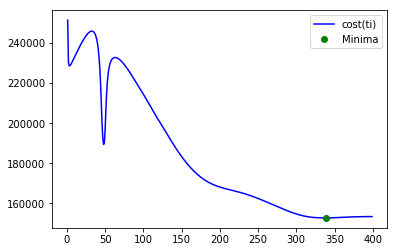

params = [   1.45958277    1.24676966   -0.27112565  246.80198745]
params_covariance = [[  1.74462598e-04  -1.29255162e-04  -2.11185881e-04  -4.55806349e-01]
 [ -1.29255162e-04   8.85113218e-04   2.42461052e-04  -1.11227411e+00]
 [ -2.11185881e-04   2.42461052e-04   3.35043878e-04  -8.63631214e-02]
 [ -4.55806349e-01  -1.11227411e+00  -8.63631214e-02   7.95856480e+03]]
standad deviation errors =  [  1.32084291e-02   2.97508524e-02   1.83042038e-02   8.92107886e+01]


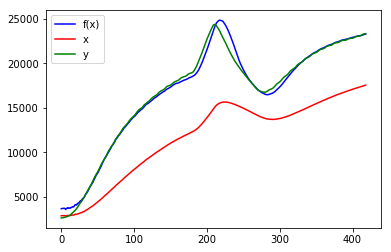

In [19]:
# 近似式を定義
def f6(xs, b, c, d, e):
    x, xdelay, xsum = xs
    dx = x - xdelay
    return b*x + c*dx + d*xsum + e

# 探索実施
result = optimize.brute(cost5_for_brute, [slice(1, 400, 1)], args=(f6, x, xdelay, y), full_output=True)
final_ti, final_cost, tis, costs = result # 最適ti, 最適cost, 探索範囲のti, それぞれのcost
final_ti = int(final_ti[0]) # [23.]のように実数のリストで返っているため、整数へ変換
print('final optimum ti = ', final_ti, 'for cost = ', final_cost)

# 可視化
fig, ax = plt.subplots()
ax.plot(tis, costs, 'b-', label="cost(ti)")
ax.plot(final_ti, final_cost, 'go', label="Minima")
ax.legend()
plt.show()

solve_and_plot_by_ti(final_ti, f6, x, xdelay, y)

***やはり２次項は必要でした。***

パラメーターの値が小さいと、寄与度が少ないのではと考えてしまいますが、実際に確認してみるまで判断はできないことが良くわかりました。

- - -

最後に、tiに大きな値を取れない(積分バッファを大きく取れない、大きな整数を扱えない、多ビットでの計算が困難)ような小さな組込みシステムのために、tiが小さいときの様子を見てみます。

## モデル5を小さなtiで運用したとき

tiは10程度にも局所解があります。この場合はどうなのでしょうか。

final optimum ti =  9 for cost =  105290.231346


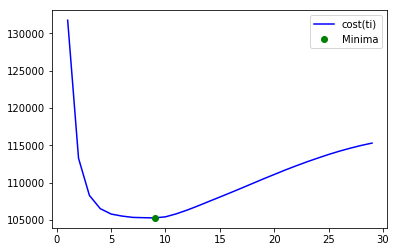

params = [ -3.35077051e-05   6.34533112e+00   8.26308638e-01  -4.35919543e+00
  -2.65976841e+03]
params_covariance = [[  9.91381369e-13   8.29449613e-10   1.80437951e-09  -2.06410309e-08
    7.13151940e-05]
 [  8.29449613e-10   4.55158040e-02  -4.96419025e-03  -4.52708548e-02
   -3.90835831e+00]
 [  1.80437951e-09  -4.96419025e-03   7.59625712e-04   4.90797861e-03
    2.31789824e-01]
 [ -2.06410309e-08  -4.52708548e-02   4.90797861e-03   4.54355845e-02
    2.30925244e+00]
 [  7.13151940e-05  -3.90835831e+00   2.31789824e-01   2.30925244e+00
    7.83076217e+03]]
standad deviation errors =  [  9.95681359e-07   2.13344332e-01   2.75613082e-02   2.13156244e-01
   8.84915938e+01]


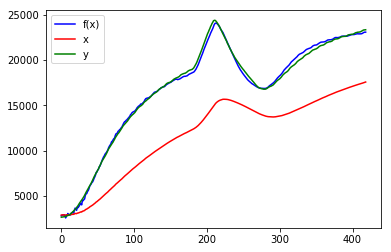

In [20]:
# 探索実施
result = optimize.brute(cost5_for_brute, [slice(1, 30, 1)], args=(f5, x, xdelay, y), full_output=True)
final_ti, final_cost, tis, costs = result # 最適ti, 最適cost, 探索範囲のti, それぞれのcost
final_ti = int(final_ti[0]) # [23.]のように実数のリストで返っているため、整数へ変換
print('final optimum ti = ', final_ti, 'for cost = ', final_cost)

# 可視化
fig, ax = plt.subplots()
ax.plot(tis, costs, 'b-', label="cost(ti)")
ax.plot(final_ti, final_cost, 'go', label="Minima")
ax.legend()
plt.show()

solve_and_plot_by_ti(final_ti, f5, x, xdelay, y)

`ti = 47` のときの最適解とくらべてもそれほど遜色ありません。

実装が難しいとき、 `ti = 9` で運用するのも妥協の範囲内であるケースは多いでしょう。

# まとめ

結局PID(比例・積分・微分) + ２次項でうまく近似できました。

今回対象とした元々の対象が古典的な制御系に近い題材だったので、その方面の方には予想される答えかと思います。
そういった近似式を思い浮かべることが出来るとき、Pythonでscipyをうまく使うと、手軽に確認しながら、適したパラメーターを探すことができると思います。

またそのときJupyter Notebookを使って、技術メモをデータや計算式と一緒に残すのが一番早いのでは、と思います。

## 余談

- 今回の題材は、数年前忙しかったため、同僚に近似式を見つけて解決してもらっていたものでした。
- しかし近似式は作られたものの、運用はハンドエンジニアリングでパラメーターを探していました。それなりに近似できていたし、特にクリティカルではないためそのまま放置されていました。
- 実は、その近似式は微分項までしか使っていませんでした(今回のモデル3相当)。疑ったわけではありませんでしたが、最適なの? ということはとても頭によぎっていました。
- 何故積分を使わなかったのか、そのことを含めてある程度まで深めてみた今回の活動となりました。

今回しつこく調べた結果、以下のことは活かせそうです。

- パラメーターの最適化を自動化出来ることになった。
- もっと良い、**小さなシステムに実装できる**近似式が少なくとも１つわかった。